# Introduction to Scikit-Learn ("sklearn")

This notebook is a short tutorial that

 1. Covers how to create classifiers using the sklearn API
 2. Covers how to create transfomers using the sklearn API
 3. Covers how to link transformers and classifiers together using `Pipeline`s
 4. Covers how to integrate Pandas with the sklearn API.
 
This is not an introduction to machine-learning. This is solely about method names, class inheritance trees, and basic sklearn wiring. The intent is to ensure all of our code adheres to the same API across all projects. 

Within Onzo, the projects that use sklearn extensively are DUC and Forecasting. PLD uses it slightly. Occupancy-detection should use it extensively.

If time allows, we'll discuss bridging PySpark and Sklearn.

In [90]:
import numpy as np
import numpy.random as rd
from typing import Optional, List
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# The Classifier API

We demonstrate how to make a custom classifier to see if a person is tall.

Our classifier just takes the average height for tall people, the average other for everyone else, and predics tall if your height is closer to the former than the latter. 

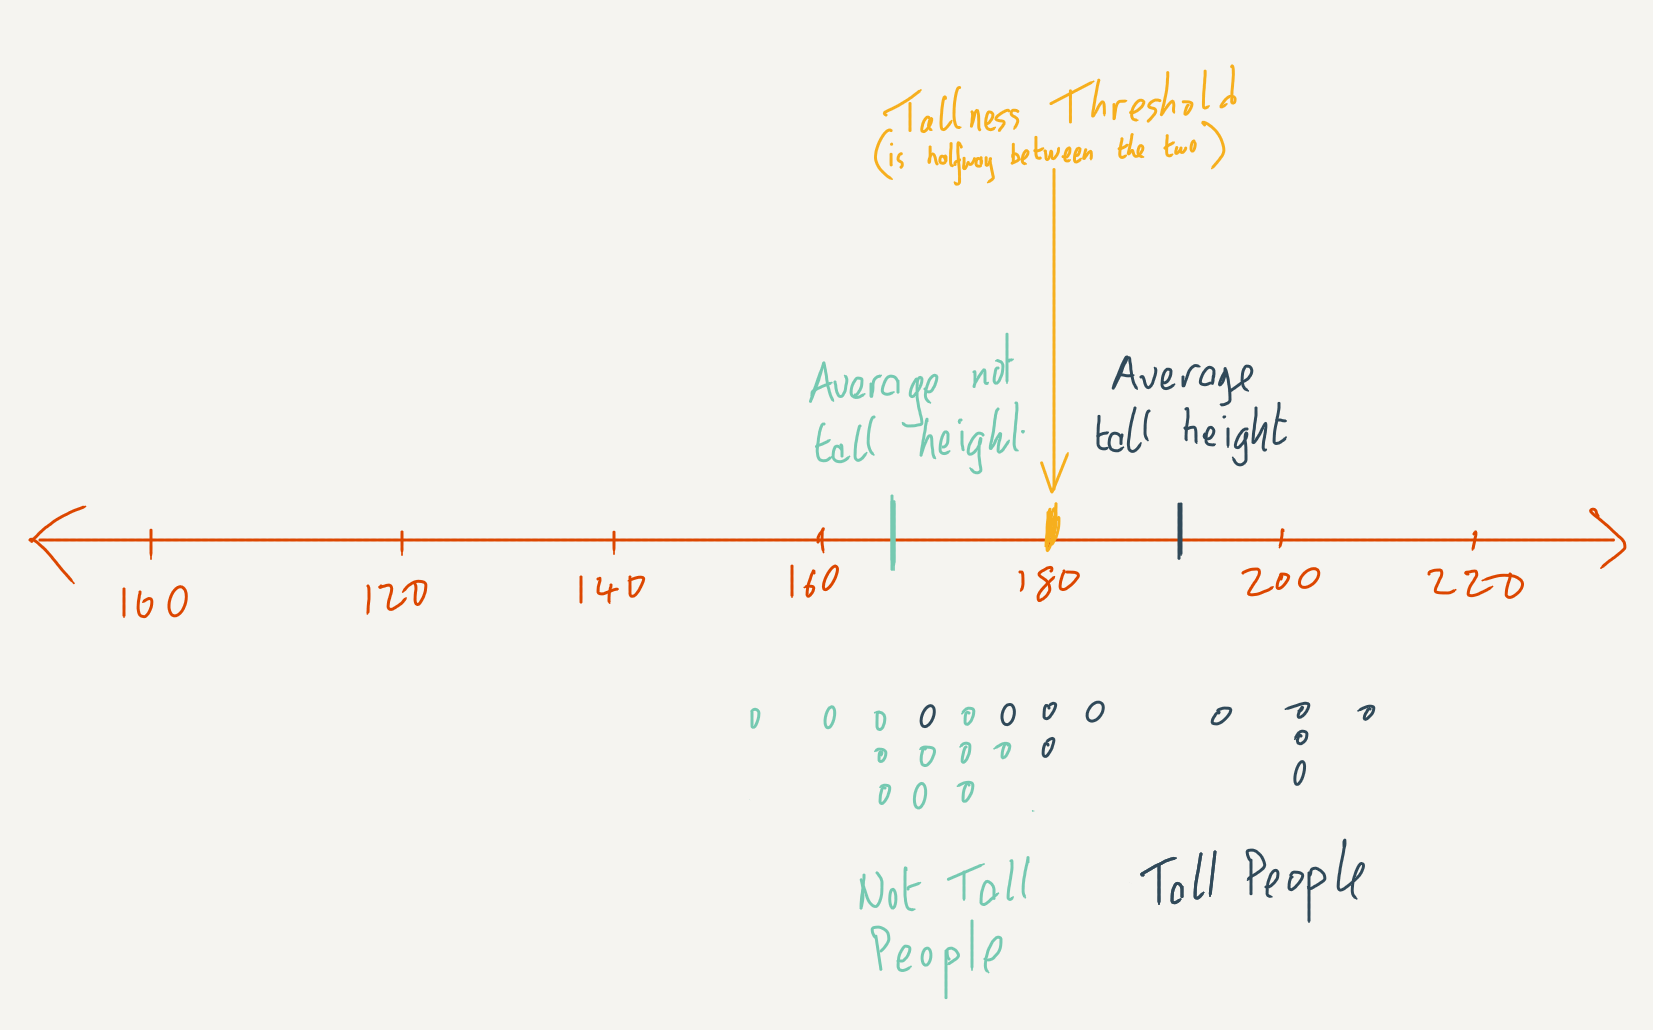

## Training Data

First we create our training data (in cm)

In [2]:
AVERAGE_HEIGHT = 180
TALL_HEIGHT = 190
TRAINING_DATA_SAMPLE_SIZE = 100

heights = rd.poisson(AVERAGE_HEIGHT, size=TRAINING_DATA_SAMPLE_SIZE)
is_tall = heights > TALL_HEIGHT

Obviously this is all very artificial, but lets pretend human beings did the classification

## Basic Sklearn Classifier

In [22]:
class TallClassifier():
    threshold: Optional[float]
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> "TallClassifier":
        tall_avg = X[y].mean()
        not_tall_avg = X[~y].mean()
        self.threshold = not_tall_avg + (tall_avg - not_tall_avg) * 0.5
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        return X[:,0] > self.threshold
    
    def fit_predict(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(X, y).predict(X)

## Classifier in Action

We'll hold out 5 samples just for evaluation

In [24]:
c = TallClassifier()

X = heights.reshape(len(heights), 1)
y = is_tall

train_X, train_y = X[:-5, :], y[:-5]
test_X, test_y = X[-5:, :], y[-5:]

c.fit(train_X, train_y)
pred_y = c.predict(test_X)

list(zip(test_y, pred_y))

[(True, True), (False, False), (False, True), (False, False), (False, False)]

## Basic Sklearn API for a Classifier

Traditionally operate on numpy arrays and vectors.

 1. `fit(X, y)` _must_ return a reference to the classifier. If it needs to, it can use the data to learn parameters, but it can also just ignore them
 2. `predict(X)` performs the classification and returns the result
 3. `fit_predict(X, y)` links fit and predict together.
 4. `__init__()` should take extra configuration parameters. You _cannot_ add extra parameters to `fit(X, y)` or `predict(X)`
 
This is all duck-typed: there's no interface, but all the other supporting classes can't work if you don't follow this convention.

## Filling out the Edges: BaseEstimator I

This is just coding to a convention so far. The first thing you can do is use `BaseEstimator` to control how parameters are set (`get_params()` andd `set_params()`). and a nice `__str__()` implementation.

In [25]:
# Before

str(c)

'<__main__.TallClassifier object at 0x102190fd0>'

## Filling out the Edges: BaseEstimator II

In [26]:
from sklearn.base import BaseEstimator

class TallClassifier2(BaseEstimator):
    threshold: Optional[float]
    height_split_percent: float
        
    def __init__(self, height_split_percent = 0.5):
        self.height_split_percent = height_split_percent
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> "TallClassifier":
        tall_avg, not_tall_avg = X[y].mean(), X[~y].mean()
        self.threshold = not_tall_avg + (tall_avg - not_tall_gvg) * self.height_split_percent
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        return X[:,0] > self.threshold
    
    def fit_predict(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(X, y).predict(X)

## Filling out the Edges: Base Estimator III 

In [27]:
c = TallClassifier2()
str(c)

'TallClassifier2()'

In [28]:
c = TallClassifier2(height_split_percent=0.75)
str(c)

'TallClassifier2(height_split_percent=0.75)'

In [29]:
c.get_params()

{'height_split_percent': 0.75}

In [30]:
c.set_params(height_split_percent=0.25)
str(c)

'TallClassifier2(height_split_percent=0.25)'

## Filling out the Edges: ClassifierMixin I

This just defines a `score()` method that takes some sample inputs and outputs, and outputs how well your classifier performed

In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TallClassifier3(BaseEstimator, ClassifierMixin):
    threshold: Optional[float]
    height_split_percent: float
        
    def __init__(self, height_split_percent = 0.5):
        self.height_split_percent = height_split_percent
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> "TallClassifier":
        self.threshold = (X[y].mean() + X[~y].mean()) * self.height_split_percent
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        return X[:,0] > self.threshold
    
    def fit_predict(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(X, y).predict(X)

## Filling out the Edges: ClassifierMixin II

In [32]:
c = TallClassifier3()
c.fit(train_X, train_y)

c.score(test_X, test_y)

0.8

Just to prove that that worked...

In [33]:
opposite_of_test_y = ~test_y

c.score(test_X, opposite_of_test_y)

0.2

# Freebies 1: Cross Validation

Instead of just holding out the last 10 records, segment your data into, say, 5 slices. Use four for training, then the fifth for testing. Do it 5 times, with a different test slice each time. This gives you an idea of how well your classifier works outside of the training data, i.e. what will happen in prod.

![Cross Validation Diagrame](CrossValidation.png)

## Freebies 1: Cross Validation

In [34]:
from sklearn.model_selection import cross_val_score

c = TallClassifier3()

cross_val_score(c, X, y, cv=5)

array([0.95, 1.  , 0.9 , 0.75, 0.95])

The `cross_val_score` also has a `groups` parameter if you want to ensure a certain balance in all the slices, and a `n_jobs` parameter, if you want to parallelize things

## Freebies 2: Grid Search of Parameters

It's typical to have parameters like `height_split_percent` that you need to tune to control how your classifier learns. Because 

1. the `BaseEstimator` provides a way to programmatically inspect and set parameters, and 
2. the `ClassifierMixin` provides a way to determine how well your classifier performs given a parameterisation

You can get -- for free -- an easy way to exhaustively search all possible parameter values ("grid search"). 


## Freebies 2: Grid Search of Parameters

In [41]:
from sklearn.model_selection import GridSearchCV

c = TallClassifier3()
g = GridSearchCV(
    c,
    param_grid={
        'height_split_percent': [0.10, 0.25, 0.50, 0.75, 1.00]
    },
    verbose=True  # Note how this is param of init() and not fit() 
)
g.fit(X, y)
g.best_estimator_  # inferred params end with an underscore

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


TallClassifier3()

## Freebies 2: Grid Search of Parameters

In [42]:
g.cv_results_

{'mean_fit_time': array([0.00018473, 0.00013595, 0.00013494, 0.00014043, 0.00019784]),
 'std_fit_time': array([4.26545164e-05, 1.96257740e-06, 1.04469787e-06, 6.43288496e-06,
        5.78917230e-05]),
 'mean_score_time': array([0.00034823, 0.00017128, 0.00016999, 0.00022378, 0.00023084]),
 'std_score_time': array([3.09081329e-04, 1.81949463e-06, 3.13771894e-06, 7.05562071e-05,
        2.09994667e-05]),
 'param_height_split_percent': masked_array(data=[0.1, 0.25, 0.5, 0.75, 1.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'height_split_percent': 0.1},
  {'height_split_percent': 0.25},
  {'height_split_percent': 0.5},
  {'height_split_percent': 0.75},
  {'height_split_percent': 1.0}],
 'split0_test_score': array([0.25, 0.25, 0.95, 0.75, 0.75]),
 'split1_test_score': array([0.25, 0.25, 1.  , 0.75, 0.75]),
 'split2_test_score': array([0.25, 0.25, 0.9 , 0.75, 0.75]),
 'split3_test_score': array([0.25, 0.25, 0.75, 

# Recap - Basics

To make a classifier:
    
 1. Standard methods: `fit(X, y)`, `predict(X)`, `fit_predict()`
 2. Any extra parameters are passed to `__init__()`.
     * **Don't be tempted  to put extra  parameters into `fit()` or `predict()`**
 3. Extend `BaseEstimator` (or implement `get_params()` and `set_params()`)
 4. Extend `ClassifierMixin` (or implement `score()`)
 
To make a regressor (predicting numbers instead of categories), it's exactly as above except replace step 4 with

<ol start=4>
    <li>Extend <code>RegressorMixin</code> (or implement <code>score()</code>)</li>
</ol>

# Recap - What if you have no training to do?

In [46]:
class TallClassifier4(BaseEstimator, ClassifierMixin):
    threshold: float
        
    def __init__(self, height_threshold: float):
        self.threshold = height_threshold
        
    def fit(X: np.ndarray,  y: np.ndarray) -> "TallClassifier4":
        return self
    
    def predict(X: np.ndarray) -> np.ndarray:
        return X[:, 0] > self.threshold
    
    def fit_predict(X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(X, y).predict(X)
    
c = TallClassifier4(180)

# Recap - Pandas Discussion

Scikit-Learn originally worked on Numpy arrays and vectors. However since it's duck-typed, you can use anything. In custom work, I'd strongly recommend using `DataFrame`s and `Series`, preserving the index between the two, e.g.

```
   def fit(X: pd.DataFrame, y: pd.Series) -> "MyClassifier"
      ...
      
   def predict(X: pd.DataFrame) -> pd.Series:
      ...
```

I'll return to this at the end

# Recap - Mutability and Repeated Training

Mutability

 * Despite returning a class instance, all `fit()` implementations I've seen mutate the class itself in-place.

What happens if you  call `fit()` twice?

 * This is implementation dependent
 * Some implementations of some algorithms will generate entirely new parameter estimates without regard to the previous estimates
 * Some will use the new data to adjust the previously trained estimates
 * Need to document

# Recap - Probabilities

It always helps quantify how certain you are for a classification. If you can output a probability, you shouldd

1. Implement `__init__()`, `fit(X, y)`, `predict(X)`, `fit_predict(X, y)` as usual
2. And additionally implement 
 1. `predict_proba(X)` giving the probability of the decision(s)
 2. `predict_log_proba(X)` the natural log of `predict_proba()`
 
Frequently `predict_proba()` will underflow and return zero due to the finite precision of IEEE754. `predict_log_proba()` is safer.

# The Transformer API

Often we need to do a lot of data pre-processing before we can feed to to a classifier or regressor. There are several steps

 1. The just basics of converting non-numeric data to numeric data
 2. Outlier elimination, if appropriate for your model ([sample here](https://scikit-learn.org/0.18/auto_examples/covariance/plot_outlier_detection.html))
 3. Handling missing features using [imputation](https://scikit-learn.org/stable/modules/impute.html#impute)
 3. Creation of extra features (e.g. [feature-interaction terms with polynomial features](https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features))
 3. Ensuring the data has the statistical properties that are required for your model to work (e.g. [centering and scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)) 
 
Some transformers are hard rules, but some (e.g. centering and scaling) require training themselves

# Sample Transformer: Inches to Centimetres

In [176]:
CM_PER_INCH = 2.54

class UnitTransform(BaseEstimator):
    multiple: float

    def __init__(self, multiple: float = CM_PER_INCH):
        self.multiple = multiple
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> "UnitTransform":
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X[:,0] * self.multiple).reshape(len(X), 1)  # must be a 2-d array
    
    def fit_transform(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(X, y).transform(X)   

# BaseEstimator and Transforms

As you can see, you can configure transforms based on fixed parameters (via `__init__()`), and on parameters learned from the data (via `fit()`). 

Hence `BaseEstimator`

In [175]:
CM_PER_FOOT = CM_PER_INCH * 12

t = UnitTransform(multiple=CM_PER_FOOT)

t.get_params()

{'multiple': 30.48}

# TransformerMixin

Just provides a default `fit_transform()` implementation

In [177]:
from sklearn.base import TransformerMixin

class UnitTransform(BaseEstimator, TransformerMixin):
    multiple: float

    def __init__(self, multiple: float = CM_PER_INCH):
        self.multiple = multiple
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> "UnitTransform":
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X[:,0] * self.multiple).reshape(len(X), 1)  # must be a 2-d array

# When do you train Transformers

One sample is mapping text to numbers.

In [178]:
class WordTransform(BaseEstimator, TransformerMixin):
    words_list: List[str]
        
    def __init__(self):
        self.words_list = []
    
    def fit(self, X: np.ndarray) -> "WordTransform":
        for row in range(len(X)):
            word = X[row, 0]
            if word not in self.words_list:
                self.words_list.append(word)
        return self
                
    def transform(self, X: np.ndarray) -> np.ndarray:
        X_out = np.zeros(X.shape, dtype=np.int32)
        for row in range(len(X)):
            X_out[row, 0] = self.words_list.index(X[row, 0])
        return X_out

# When do you train Transformers

In [179]:
X = np.array([['cat', 'dog', 'cat', 'mouse', 'dog', 'dog']]).T

t = WordTransform()
t.fit_transform(X)

array([[0],
       [1],
       [0],
       [2],
       [1],
       [1]], dtype=int32)

# Simple Shortcut to a Transformer Implementation

Most transformers don't need training, and don't have any parameters you would ever want to grid-search.

In such cases, it's a lot of effort to create a class just to wrap a `transform()` method.

So sklearn provides a class `FunctionTransformer` which wraps such a function



# Simple Shortcut to a Transformer Implementation

E.g. a transformer that just returns the third column of a DataFrame

In [180]:
from sklearn.preprocessing import FunctionTransformer

t = FunctionTransformer(
    func=lambda df: df.iloc[:, 2],
    inverse_func=None,    # We don't provide a function to undo this transform
    check_inverse=False,  # So we don't check that it works
    validate=False       # We don't check the input is a 2d numpy matrix
)

In [181]:
df = pd.DataFrame({'a':[1, 1, 1], 'b':[2, 2, 2], 'c':[3, 3, 3]})

t.fit_transform(df)

0    3
1    3
2    3
Name: c, dtype: int64

# Recap

To make a transformr:
    
 1. Standard methods: `fit(X)`, `transform(X)`.
     1. You can also have `fit(X, y)` `transform(X)` if we you want
 2. Any extra parameters are passed to `__init__()`.
     * Don't be tempted  to put extra  parameters into `fit()` or `predict()`
 2. Optionally an `inverse_transform(X)` method -- rarely needed.
 3. Extend `BaseEstimator` (or implement `get_params()` and `set_params()`)
 4. Extend `TransformerMixin` (or implement `fit_transform()`)
 
If you don't have any parameters to fit, it might just be easier to create a function and wrap it in a `FunctionTransformer`

But beware of the interaction with lambdas and closures: see appendix below.

# Pipelines

Pipelines are use to combine transformers and and classifier (or regressor) into a single object with `fit()` and `predict()` methods. Consider this dataset:

In [182]:
names = ['Bob', 'Tom', 'Jim', 'Rob', 'Ann', 'Joy', 'May', 'Tim', 'Jon', ''] * (TRAINING_DATA_SAMPLE_SIZE // 10) 


d = pd.DataFrame({'name': names, 'height_inches': heights / 2.5, 'is_tall': is_tall})
d.head(4)

,name,height_inches,is_tall
0,Bob,67.6,False
1,Tom,76.0,False
2,Jim,64.8,False
3,Rob,69.2,False


## Simple Pipeline

In [186]:
from sklearn.pipeline import Pipeline

p = Pipeline(
    [
        ('select_column', FunctionTransformer(func=lambda df: df[['height_inches']].values,
                                              check_inverse=False, validate=False)),
        ('convert_to_cm', UnitTransform(multiple=CM_PER_INCH)),
        ('predict', TallClassifier3())
    ], 
    verbose=False
)

p.fit_predict(d, d['is_tall'])

array([False,  True, False, False, False, False, False,  True, False,
       False,  True,  True, False, False, False,  True,  True, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
        True,  True, False, False, False, False, False,  True,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
       False,  True, False, False, False,  True,  True, False, False,
       False,  True, False, False,  True,  True, False,  True, False,
       False])

## Simple Pipeline Extended - GridSearch I

Since pipelines fit the classifier/regressor API, you can put pipelines within pipelines, or wrap pipelines with wrapper classes, e.g. for a grid-search

In [187]:
g = GridSearchCV(
    p,
    param_grid={
        'predict__height_split_percent': [0.10, 0.25, 0.50, 0.75, 1.00]
    },
    verbose=True  # Note how this is param of init() and not fit() 
)
g.fit(d, d['is_tall'])
g.best_estimator_  # inferred params end with an underscore

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


Pipeline(steps=[('select_column',
                 FunctionTransformer(check_inverse=False,
                                     func=<function <lambda> at 0x179652320>)),
                ('convert_to_cm', UnitTransform()),
                ('predict', TallClassifier3())])

## Simple Pipline Extended - GridSearch II

In [188]:
p.get_params()

{'memory': None,
 'steps': [('select_column',
   FunctionTransformer(check_inverse=False,
                       func=<function <lambda> at 0x179652320>)),
  ('convert_to_cm', UnitTransform()),
  ('predict', TallClassifier3())],
 'verbose': False,
 'select_column': FunctionTransformer(check_inverse=False,
                     func=<function <lambda> at 0x179652320>),
 'convert_to_cm': UnitTransform(),
 'predict': TallClassifier3(),
 'select_column__accept_sparse': False,
 'select_column__check_inverse': False,
 'select_column__func': <function __main__.<lambda>(df)>,
 'select_column__inv_kw_args': None,
 'select_column__inverse_func': None,
 'select_column__kw_args': None,
 'select_column__validate': False,
 'convert_to_cm__multiple': 2.54,
 'predict__height_split_percent': 0.5}

## Sklearn and Pandas Integration

From the `sklearn-pandas` library you can use a class called `DataframeMapper` to apply a transform to a subset of a data-frames columns, e.g.

```
>>> mapper = DataFrameMapper([
...     ('pet', sklearn.preprocessing.LabelBinarizer()),
...     (['children', 'adults'], sklearn.preprocessing.StandardScaler()),
...     ('keep_me', None),
... ])
```

This will only return three columns, since only three went in. If you want to return additional columns, without transforming them, just include them with `None` set as the transform.

For more information look at the [sklearn-pandas documentation](https://github.com/scikit-learn-contrib/sklearn-pandas)


## Recap

  1. Pipelines allow you to encapsulate the entire feature-generation and prediction process in a single object
  2. Each stage is named, and you can use names to do a grid-search for predictor and/or transformer parameters
  3. Pipelines adhere to the classifier/regressor API (`fit()`/`predict()`) andd so 
      1. Can be embedded in other pipelines (as the final stage)
      2. Wrapped in other sklearn wrappers like GridSearchSV
      3. Passed to other sklearn functions like `cross_val_score()`.
  4. Pipelines can be serialised into a pickle file as a single unit. This is what we do in `analytics-forecasting`.
  5. Pipelines are used in analytics-forecasting and DUC.

# Appendix 1: Issues with Lambdas and Closures

Python lambdas (functioned defined inline) are technically called closures, as they capture (“close over”) the variables in their environment, i.e. you can do something like

---
```
i = 3
add_three = lambda x: x+i

print(add_three(3))
```
---
```
6
```
However it’s worth nothing that Python is a mutable, object-orientated language, where even simple “primitive”-looking variables such as i are objects. What happens if we run a for-loop?

---
```
fns = {}
for i in [0, 1, 2]:
    fns[f'add {i}'] =  lambda x: x + i
    
print(fns['add 0'](3))
print(fns['add 1'](3))
print(fns['add 2'](3))
```
---
```
5
5
5
```
All three lambdas refer to the same instance of the variable `i` which is being mutated in-place by the for-loop, and (unlike C or Java) exists in the outer scope where the for-loop is defined. The last time `i` is mutated, it is set to `2`, which is why every function ultimately adds `2` to its input.

How to fix this? One is to change the scope that’s being captured by the closure (aka lambda). The easiest way is to cross a function boundary

---
```
from typing import Callable

def make_add_fn(i: int) -> Callable[[int, int], int]:
    # i here is a new, unchanging, local variable; which falls out of scope
    # when we leave the function, but retains a reference via the lambda 
    return lambda x: x + i
    
fns = {}
for i in [0, 1, 2]:
    fns[f'add {i}'] = make_add_fn(i)
    
print(fns['add 0'](3))
print(fns['add 1'](3))
print(fns['add 2'](3))
```
---
```
3
4
5
```

Where this becomes interesting/relevant/a nightmare for your local data-scientist is that if you u\se `sklearn.Pipeline`, you may end up creating data processing stages using lambdas wrapped up in `FunctionTransformer` objects. If you are, be careful that the scope that you’re capturing is immutable. 